# Time Aware Symbols

The `TimeAwareSymbol` object is an extension of `sympy.Symbol`. It is an important building block of DSGE models. This short tutorial shows what they are, and how they can be used. 

In [1]:
import sys

sys.path.append("/Users/jessegrabowski/Documents/Python/gEconpy/")

In [2]:
import sympy as sp

from gEconpy.classes.time_aware_symbol import TimeAwareSymbol

## Basic Functionality

A `TimeAwareSymbol` functions exactly like `sp.Symbol`, except that it accepts a `time_index` argument. `time_index` is an integer that gives an offset from time `t`. Here are three examples:

In [3]:
x_t = TimeAwareSymbol("x", time_index=0)
x_tm1 = TimeAwareSymbol("x", time_index=-1)
x_tp1 = TimeAwareSymbol("x", time_index=1)

In [4]:
x_t

x_t

In [5]:
x_tm1

x_t-1

In [6]:
x_tp1

x_t+1

The variable is build from the provided `base_name` (in this case `x`), and the `time_index`. The `name` is constructed by combining these two elements.

In [7]:
x_t.name

'x_t'

In [8]:
x_t.base_name

'x'

In [9]:
x_t.time_index

0

There is also a `safe_name`, which can be used in contexts where the `+` or `-` in the name would be problematic. For the `safe_name`, `+` is replaced with `p`, and `-` with `m`.

In [10]:
x_tp1.name

'x_t+1'

In [11]:
x_tp1.safe_name

'x_tp1'

In [12]:
x_tm1.safe_name

'x_tm1'

Otherwise, all other arguments to `sp.Symbol` can be specified. For example, assumptions are allowed:

In [13]:
x_t_positive = TimeAwareSymbol("x", time_index=0, positive=True)
x_t_positive

x_t

In [14]:
x_t_positive.assumptions0

{'positive': True,
 'extended_nonpositive': False,
 'extended_positive': True,
 'hermitian': True,
 'nonnegative': True,
 'extended_real': True,
 'zero': False,
 'extended_negative': False,
 'extended_nonnegative': True,
 'nonpositive': False,
 'complex': True,
 'nonzero': True,
 'finite': True,
 'imaginary': False,
 'real': True,
 'commutative': True,
 'infinite': False,
 'extended_nonzero': True,
 'negative': False}

## Time manipulations

After creation, several methods for manipulating the time index of the variable are available:

- `step_forward` increments the `time_index`
- `step_backward` decremetes the `time_index`
- `set_t` allows `time_index` to be set directly

In [15]:
x_t.step_forward()

x_t+1

In [16]:
x_t.step_backward()

x_t-1

The most important feature of `TimeAwareSymbol`s is that when two `TimeAwareSymbol`s have the same `base_name` and `time_index`, they evaulate as equal

In [17]:
x_t.step_backward() == x_tm1

True

In [18]:
x_t.step_forward() == x_tp1

True

### Steady State

Another important concept in analysis of dynamic systems is a "steady state". A steady state is an equlibrium such that $x_t = x_{t+1} = x_{t+1} = \dots = x_{ss}$ 

Variables can be sent to the steady state using the `to_ss` method

In [19]:
x_t.to_ss()

x_ss

Since 'ss' is a special `time_index`, variables of the same `base_name` sent to the steady state will evaluate to equal

In [20]:
x_t.to_ss() == x_tp1.to_ss()

True

# Working with Equations

`TimeAwareSymbols` subclass `Symbol`, so anything you can do with a symbol can be done with a `TimeAwareSymbol`.

For example, you can do algebraic manipulations

In [21]:
eq = sp.Eq(x_tp1, (x_t + x_tm1) / 2)
eq

Eq(x_t+1, x_t/2 + x_t-1/2)

Or call `sympy.solve`

In [22]:
sp.solve(eq, x_t)[0]

2*x_t+1 - x_t-1

Usually, though, you are going to want to manipulate the time indices for entire expressions. Unfortunately, there is no `TimeAwareExpr`. Instead, `gEconpy` gives some helper functions for manipulation of equations that include `TimeAwareSymbols`. These are:

- `step_equation_forward`
- `step_equation_backward`
- `eq_to_ss`

The equations do what the names suggest

In [23]:
from gEconpy.utilities import (
    eq_to_ss,
    step_equation_backward,
    step_equation_forward,
)

In [24]:
step_equation_forward(eq)

Eq(x_t+2, x_t/2 + x_t+1/2)

In [25]:
step_equation_backward(eq)

Eq(x_t, x_t-1/2 + x_t-2/2)

In [26]:
eq_to_ss(eq.lhs - eq.rhs)

0

# Example 1: $AR(1)$ to $MA(\infty)$

Using these tools, we can do powerful analysis on time series. 

Consider an AR(1) system:

$$ x_t = \rho x_{t-1} + \epsilon_t$$

We can use `step_equation_backward` together with repeated substitution to derive the $MA(\infty)$ form of the $AR(1)$ system

In [27]:
eps_t = TimeAwareSymbol("\\varepsilon", 0)
rho = sp.Symbol("rho", positive=True)

# This is only the right-hand side, remember there's an x_t on the left
ar_1_rhs = rho * x_tm1 + eps_t

We will iterative shift the equation backwards and substitute

In [28]:
curr_x = x_t
curr_rhs = ar_1_rhs.copy()
for _ in range(10):
    display(sp.Eq(x_t, ar_1_rhs))
    curr_x = curr_x.step_backward()
    curr_rhs = step_equation_backward(curr_rhs)
    ar_1_rhs = ar_1_rhs.subs({curr_x: curr_rhs}).expand()

Eq(x_t, rho*x_t-1 + \varepsilon_t)

Eq(x_t, rho**2*x_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**3*x_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**4*x_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**5*x_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**6*x_t-6 + rho**5*\varepsilon_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**7*x_t-7 + rho**6*\varepsilon_t-6 + rho**5*\varepsilon_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**8*x_t-8 + rho**7*\varepsilon_t-7 + rho**6*\varepsilon_t-6 + rho**5*\varepsilon_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**9*x_t-9 + rho**8*\varepsilon_t-8 + rho**7*\varepsilon_t-7 + rho**6*\varepsilon_t-6 + rho**5*\varepsilon_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Eq(x_t, rho**10*x_t-10 + rho**9*\varepsilon_t-9 + rho**8*\varepsilon_t-8 + rho**7*\varepsilon_t-7 + rho**6*\varepsilon_t-6 + rho**5*\varepsilon_t-5 + rho**4*\varepsilon_t-4 + rho**3*\varepsilon_t-3 + rho**2*\varepsilon_t-2 + rho*\varepsilon_t-1 + \varepsilon_t)

Since $\rho \in (0, 1)$, the leading term will eventually go to zero, and we recover the well-known equation:

$$ x_t = \sum_{s=0}^t \rho^s \varepsilon_{t-s}$$

I don't know any way for sympy to automatically detect the presence of this series and rewrite into summation notation -- if you do, open an issue so I can update this example! 

# Example 2: Analytical Steady State

More useful, perhaps, is that we can use `TimeAwareSymbols` to derive the steady state of a dynamical system. Consider the AR(1) equation again:

In [29]:
ar_1 = sp.Eq(x_t, rho * x_tm1 + eps_t)
ar_1

Eq(x_t, rho*x_t-1 + \varepsilon_t)

We can send this to the steady-state and compute the value of $x_{ss}$

In [30]:
sp.solve(eq_to_ss(ar_1), x_t.to_ss())[0]

-\varepsilon_ss/(rho - 1)

Obviously we need to know something about $\varepsilon_{ss}$. We typtically assume $\varepsilon_t ~ N(0, \sigma)$. In the (deterministic!) steady state, there are no shocks, so $\varepsilon_{ss} = 0$. 

Let's generalize the equation to allow a drift in the shocks, so $\varepsilon_t ~ N(\mu, \sigma)$. We can pull out the $\mu$ using the properties of normal distributions to obtain:

$$x_t = \mu + \rho x_{t-1} + \varepsilon_t$$

In [31]:
mu = sp.Symbol("mu")
ar_1 = sp.Eq(x_t, mu + rho * x_tm1 + eps_t)
ar_1

Eq(x_t, mu + rho*x_t-1 + \varepsilon_t)

Solving for the steady state gives the well-known expression for the AR(1) steady state

In [32]:
sp.solve(eq_to_ss(ar_1).subs({eps_t.to_ss(): 0}), x_t.to_ss())[0]

-mu/(rho - 1)

# Example 3: Deterministic RBC

Consider an RBC model defined (in reduced form) as follows:

In [33]:
C, K, A, epsilon = [TimeAwareSymbol(x, 0) for x in ["C", "K", "A", "\\varepsilon"]]
alpha, beta, delta, rho = sp.symbols(
    "alpha beta delta rho",
)

euler = C.step_forward() / C - beta * (
    alpha * sp.exp(A.step_forward()) * K.step_forward() ** (alpha - 1) + 1 - delta
)
transition = K.step_forward() - (sp.exp(A) * K**alpha + (1 - delta) * K - C)
shock = A - rho * A.step_backward() - epsilon

system = [euler, transition, shock]
for eq in system:
    display(eq)

-beta*(alpha*K_t+1**(alpha - 1)*exp(A_t+1) - delta + 1) + C_t+1/C_t

C_t - K_t*(1 - delta) - K_t**alpha*exp(A_t) + K_t+1

-rho*A_t-1 + A_t - \varepsilon_t

We can use `TimeAwareSymbols` to solve for the deterministic steady state of this entire system in one fell swoop

In [34]:
ss_system = [eq_to_ss(eq).simplify().subs({epsilon.to_ss(): 0.0}) for eq in system]
ss_dict = sp.solve(ss_system, [K.to_ss(), C.to_ss(), A.to_ss()], dict=True)[0]

for var, eq in ss_dict.items():
    display(sp.Eq(var, eq))

Eq(A_ss, 0)

Eq(C_ss, -delta*((beta*(delta - 1) + 1)/(alpha*beta))**(1/(alpha - 1)) + (((beta*(delta - 1) + 1)/(alpha*beta))**(1/(alpha - 1)))**alpha)

Eq(K_ss, ((beta*delta - beta + 1)/(alpha*beta))**(1/(alpha - 1)))

Using `sp.lambdify`, we can compile a function that computes the steady state of the system given input parameters. This is essentially what `gEconpy` does internally when solving for the steady state of a DSGE model.

In [35]:
f_ss = sp.lambdify([alpha, beta, delta, rho], list(ss_dict.values()))
param_dict = {"alpha": 0.33, "beta": 0.99, "delta": 0.035, "rho": 0.95}
f_ss(**param_dict)

[0, 1.9825902234443513, 19.50030034168597]

### Phase Diagram

Since this system is deterministic, we can construct a phase diagram showing system dynamics for a given $(C_t, K_t)$ tuple. To do this, we first need to re-arrange the Euler equation and law of motion of capital to obtain rates of change, $\Delta C_{t+1}$ and $\Delta K_{t+1}$. For $\Delta C_{t+1}$ we get:

$$\begin{align}
\Delta C_{t+1} &= C_{t+1} - C_t \\
&= \beta C_t \left (\alpha K_{t+1}^{\alpha - 1} + (1 - \delta) \right ) - C_t \\
&= \left (\beta \alpha K_{t+1}^{\alpha - 1} + \beta (1 - \delta) - 1 \right ) C_t
\end{align}$$

For the second line, the Euler equation was solved for $C_{t+1}$ and substituted.

For $\Delta K_{t+1}$:

$$\begin{align}
\Delta K_{t+1} &= K_{t+1} - K_t \\
&= K_t^\alpha + (1 - \delta) K_t - C_t \\
\end{align}$$

Computing these $\Delta$s over a grid of points will give us a phase diagram. Let's look at how these can be solved for with `sympy`:

In [36]:
C_tp1 = sp.solve(euler, C.set_t(1))[0]
C_tp1

beta*C_t*(alpha*K_t+1**(alpha - 1)*exp(A_t+1) - delta + 1)

In [37]:
Delta_C = (C_tp1 - C).collect(C).subs({A.set_t(1): 0})
Delta_C

C_t*(beta*(alpha*K_t+1**(alpha - 1) - delta + 1) - 1)

This solution isn't exactly what we need, though, because we don't want the $K_{t+1}$. Use the transition equation to write it in terms of time $t$ variables only

In [38]:
K_tp1 = sp.solve(transition.subs({A: 0}), K.set_t(1))[0]
Delta_C = Delta_C.subs({K.set_t(1): K_tp1})
Delta_C

C_t*(beta*(alpha*(-delta*K_t - C_t + K_t + K_t**alpha)**(alpha - 1) - delta + 1) - 1)

In [39]:
K_tp1 = sp.solve(transition, K.set_t(1))[0].subs({A: 0})
K_tp1

-delta*K_t - C_t + K_t + K_t**alpha

In [40]:
Delta_K = K_tp1 - K
Delta_K

-delta*K_t - C_t + K_t**alpha

Compile a function with `sp.lambdify`

In [41]:
parameters = list(param_dict.keys())
f_Delta = sp.lambdify([C, K, *parameters], [Delta_C, Delta_K])

We are also interested in when $\Delta C_{t+1} = \Delta K_{t+1} = 0$, because these equations will form boundaries in phase space. We can do this by using `sp.solve`. 

First, solve $\Delta C_{t+1}$ for $C_t$. There will be two solutions, and one will be zero (since the whole expression is multiplied by $C_t$). We're only interested in the non-trivial solution.

In [42]:
boundary_1 = sp.solve(Delta_C, C)[1]
boundary_1

-delta*K_t + K_t + K_t**alpha - ((beta*delta - beta + 1)/(alpha*beta))**(1/(alpha - 1))

Next, solve $\Delta K_{t+1}$ for $C_t$

In [43]:
boundary_2 = sp.solve(Delta_K, C)[0]
boundary_2

-delta*K_t + K_t**alpha

Compile a function

In [44]:
f_boundaries = sp.lambdify([K, *parameters], [boundary_1, boundary_2])

Functions created with `sp.lambdify` are inherently vectorized, so we can make a grid of capital values and compute the associated consumpions

In [45]:
import matplotlib.pyplot as plt
import numpy as np

k_max = 120
c_max = (
    k_max ** param_dict["alpha"]
)  # We can't consume more than exists in the economy!

k_grid = np.linspace(1e-2, k_max, 100)
c_grid = np.linspace(1e-2, c_max, 100)
boundaries = f_boundaries(k_grid, **param_dict)

kk, cc = np.meshgrid(k_grid, c_grid)
with np.errstate(divide="ignore", invalid="ignore"):
    c_delta, k_delta = f_Delta(cc, kk, **param_dict)

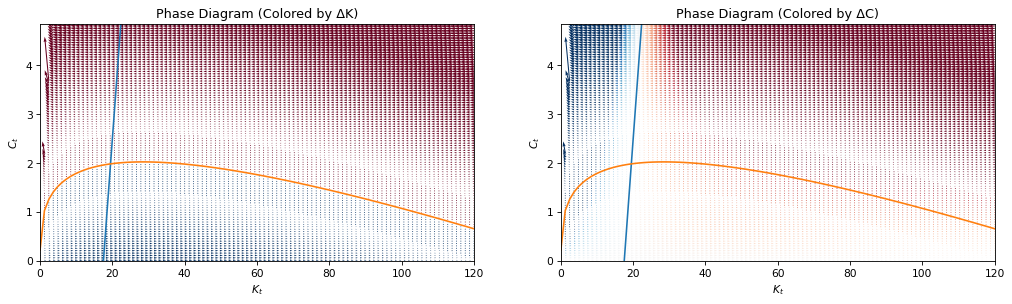

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), dpi=77)
for axis, colorby, name in zip(fig.axes, [k_delta, c_delta], ["ΔK", "ΔC"]):
    axis.plot(k_grid, boundaries[0], label="ΔK = 0")
    axis.plot(k_grid, boundaries[1], label="ΔC = 0")
    quiver_plot = axis.quiver(
        kk, cc, k_delta, c_delta, colorby, cmap=plt.cm.RdBu, clim=(-0.05, 0.05)
    )
    axis.set(
        xlim=(0, k_max),
        ylim=(0, c_max),
        xlabel="$K_t$",
        ylabel="$C_t$",
        title=f"Phase Diagram (Colored by {name})",
    )
plt.show()

# Authors

- Authored by Jesse Grabowski in March 2025

# Watermark

In [47]:
%load_ext watermark
# Delete lambdify functions (they break watermark)
del f_ss, f_Delta, f_boundaries

%watermark -n -u -v -iv -w -p gEconpy

Last updated: Thu Mar 13 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.1

gEconpy: 0+untagged.305.gd931e48.dirty

gEconpy   : 0+untagged.305.gd931e48.dirty
numpy     : 1.26.4
sympy     : 1.12.1
matplotlib: 3.10.1
sys       : 3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 07:56:32) [Clang 18.1.8 ]

Watermark: 2.5.0

